# Practical n°3: Pixel-scale Prediction - Weakly Supervised Case

## Part II: denoising with FCN - weakly-supervised approaches




In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import torch.optim as optim
from PIL import Image

First, import the functions contained in the "utile" module.

In [2]:
! git clone https://github.com/relmonta/ml-student.git

Cloning into 'ml-student'...
remote: Enumerating objects: 364, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 364 (delta 114), reused 111 (delta 90), pack-reused 210
Receiving objects: 100% (364/364), 47.12 MiB | 14.90 MiB/s, done.
Resolving deltas: 100% (154/154), done.


In [3]:
! ls

ml-student  sample_data


In [4]:
#On se branche au répertoire contenant utile.py:
os.chdir('ml-student/TP3')

In [5]:
os.listdir('.')
from utile import *

###Exercise 1: The "noise to noise" scenario

In Exercise 2, Part I, we had pairs (noisy version, clean version) to learn from. However, in real-world applications, clean versions are barely available. \
Sometimes, there are instances where multiple noisy versions are accessible. Consider, for example, photos taken with a telephoto lens with several seconds between shots: the effects of air turbulence on image quality are independent from one image to another. \
In the "noise to noise" scenario [(Lehtinen,2018)](https://arxiv.org/pdf/1803.04189.pdf), we have pairs of independently noisy images, organized into two sets $B^1_{noisy}$ and $B^2_{noisy}$.
To situate ourselves in this scenario, we utilize the synthetic images from Exercise 1. The gen_noise2noise function allows us to sample from both datasets:

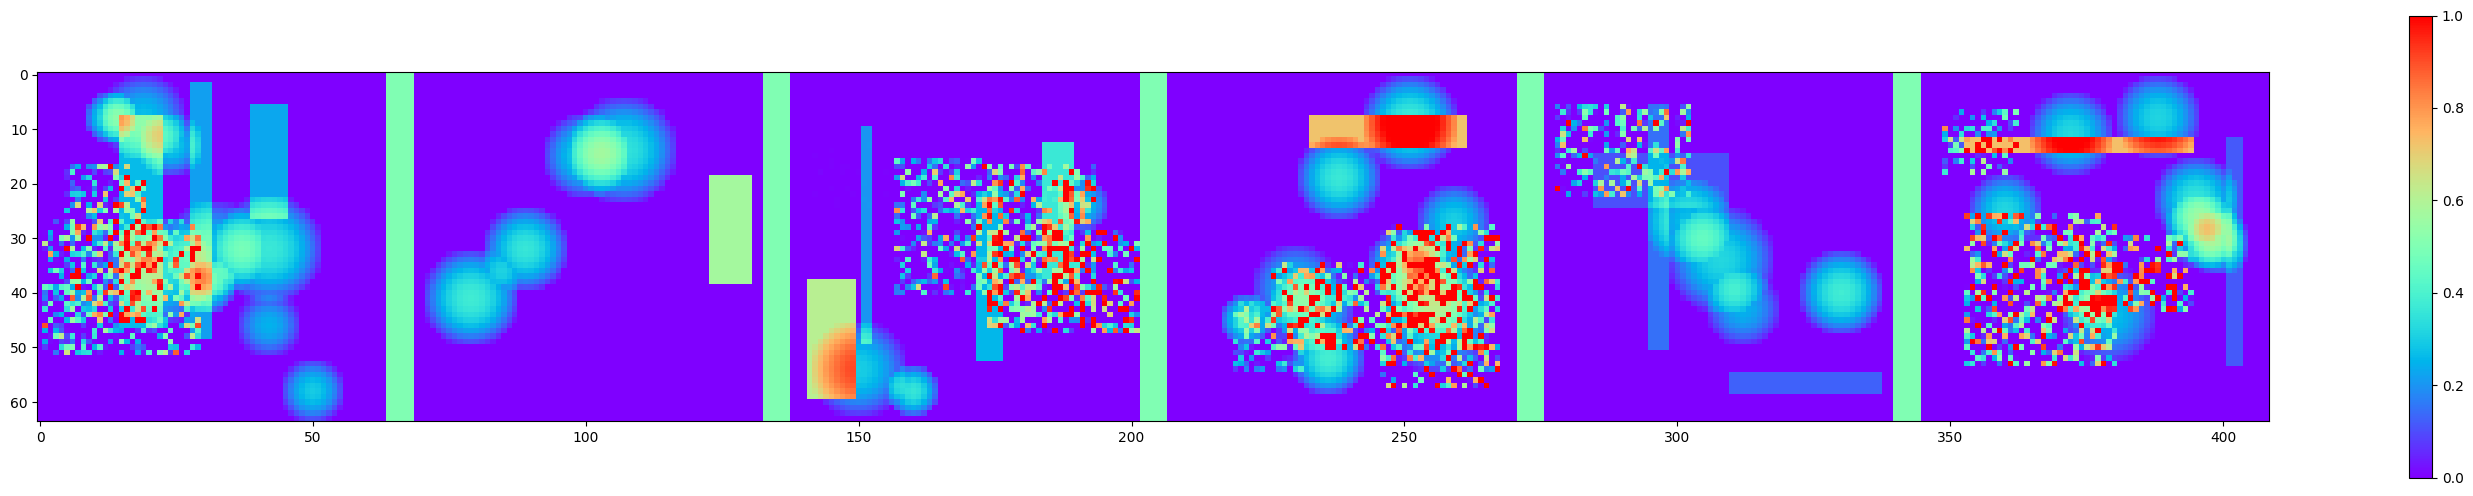

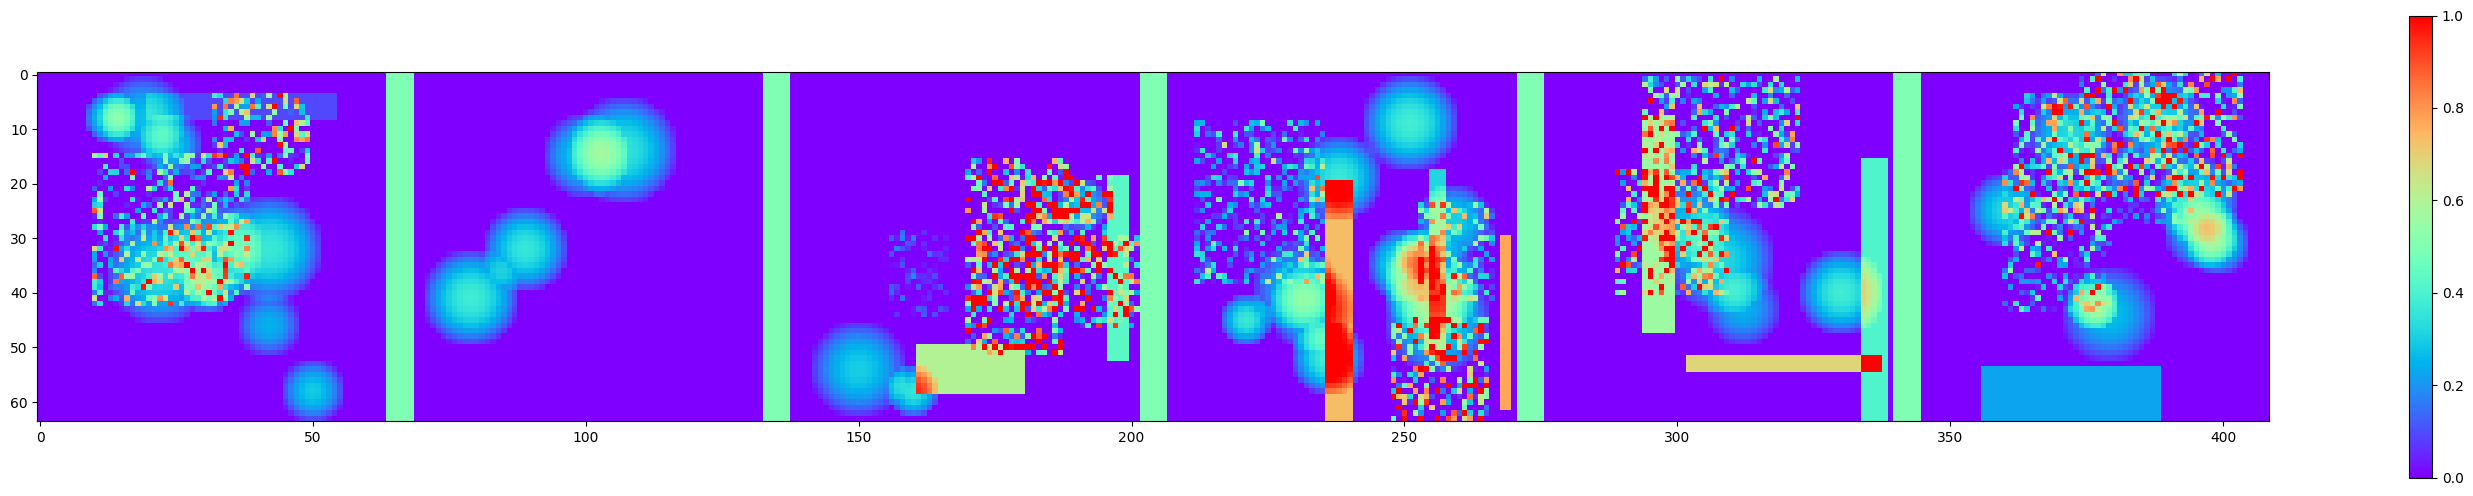

In [6]:
image1, image2 = gen_noise2noise(6)
fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(image1, 6, fig, k=0, min_scale=0,max_scale=1)

fig2 = plt.figure(1, figsize=(36, 6))
voir_batch2D(image2.detach().cpu(), 6, fig2, k=0, min_scale=0,max_scale=1)

**Q1** Define a learning procedure that effectively denoises the image.

In [7]:
fcn = UNet(1,1,16).cuda()

import torch.optim as optim
optimizer = optim.Adam(fcn.parameters(), 10**(-3))

In [8]:
nepochs = 40
nbatches = 100
batchsize = 64

train_losses = []


def criterion(output,target):
  return torch.mean(torch.abs(output - target))

for epoch in range(nepochs):

    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):
        #Load inputs

        # Generation
        input,target = gen_noise2noise(batchsize)

        # go to GPU
        input = input.cuda()
        target = target.cuda()

        # zeroing gradients, forward pass
        optimizer.zero_grad()
        output = fcn(input)

        # loss and compuation of gradients
        loss = criterion(output, target)
        loss.backward()

        # Update weights
        optimizer.step()

        epoch_losses.append(loss.detach().cpu())

        del target, input, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)
    print('epoch loss : \n')
    print(epoch_loss)

Epoch 0
epoch loss : 

0.10639267
Epoch 1
epoch loss : 

0.09005061
Epoch 2
epoch loss : 

0.08739597
Epoch 3
epoch loss : 

0.08396824
Epoch 4
epoch loss : 

0.0842407
Epoch 5
epoch loss : 

0.08467326
Epoch 6
epoch loss : 

0.083559774
Epoch 7
epoch loss : 

0.08341929
Epoch 8
epoch loss : 

0.08262876
Epoch 9
epoch loss : 

0.08363387
Epoch 10
epoch loss : 

0.082896754
Epoch 11
epoch loss : 

0.08182873
Epoch 12
epoch loss : 

0.08203778
Epoch 13
epoch loss : 

0.08223163
Epoch 14
epoch loss : 

0.08133714
Epoch 15
epoch loss : 

0.081963204
Epoch 16
epoch loss : 

0.08040443
Epoch 17
epoch loss : 

0.08082776
Epoch 18
epoch loss : 

0.081160724
Epoch 19
epoch loss : 

0.08149696
Epoch 20
epoch loss : 

0.080558226
Epoch 21
epoch loss : 

0.08053139
Epoch 22
epoch loss : 

0.08103096
Epoch 23
epoch loss : 

0.0809251
Epoch 24
epoch loss : 

0.08158261
Epoch 25
epoch loss : 

0.08095772
Epoch 26
epoch loss : 

0.081354424
Epoch 27
epoch loss : 

0.07914248
Epoch 28
epoch loss : 

0.

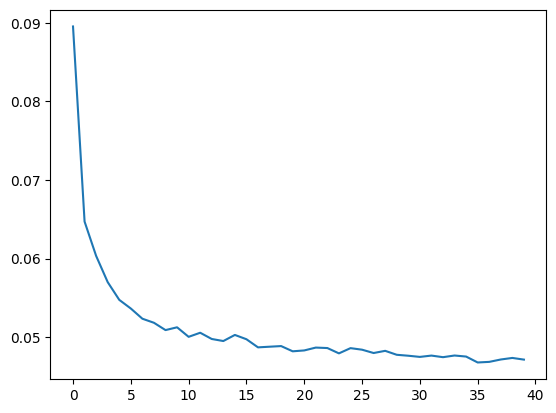

In [16]:
plt.plot(train_losses)

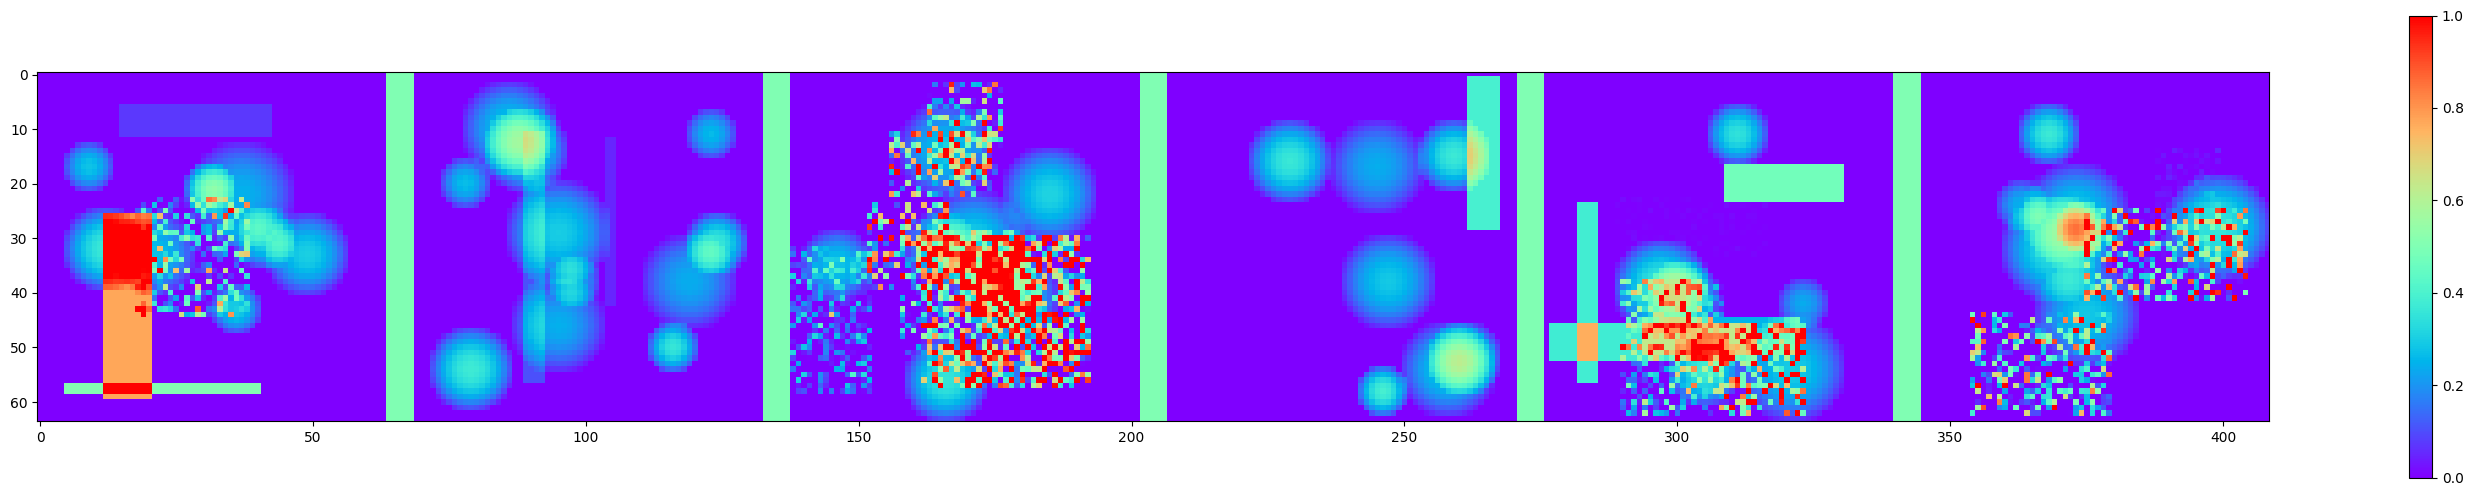

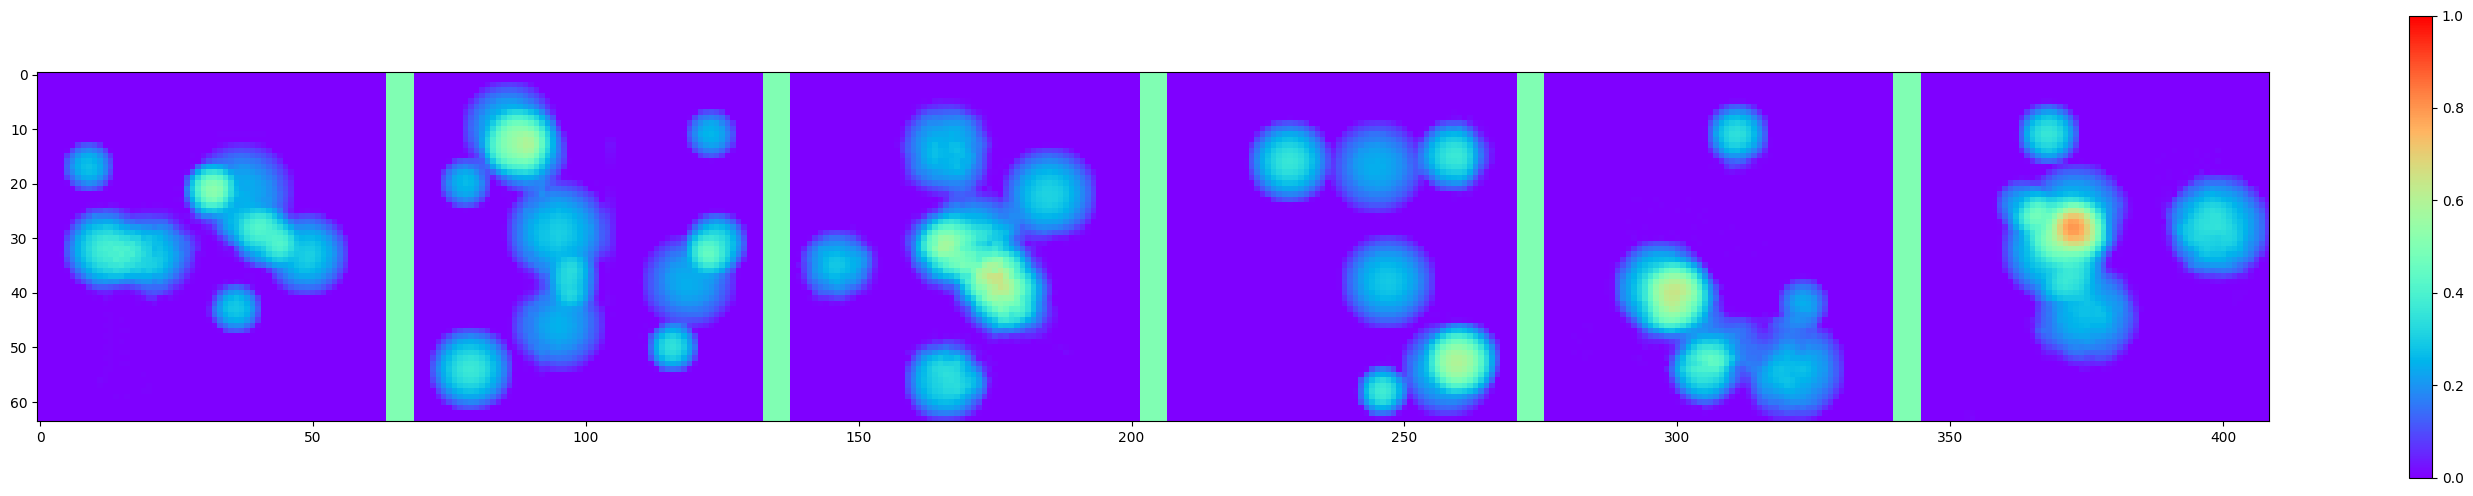

In [10]:
# viz:

fcn.eval()
input, target = gen_noise2noise(6)
input = input.cuda()

output = fcn(input)

output = output.to('cpu').detach()

input = input.to('cpu')

fig3 = plt.figure(2, figsize=(36, 6))
voir_batch2D(input, 6, fig3, k=0, min_scale=0,max_scale=1)

fig4 = plt.figure(3, figsize=(36, 6))
voir_batch2D(output, 6, fig3, k=0, min_scale=0,max_scale=1)

### TODO ###


**Q2** Theoretical analysis.

The training procedure involves searching for the weights $\theta^*$ that satisfy:

\begin{equation}
\theta^* = \underset{\theta}{argmin} {\big \{} \mathbb{E}_{(X,Y)}[ \ \mathcal{L} (f_\theta(X), Y) \ ] {\big \}} \tag{1}
\end{equation}

Rewrite equation (1) to justify the approach taken for **Q1**.

We rewrite the expectation to be minimized in the case of a cost function equal to the Mean Absolute Error (MAE):

\begin{equation}
 \mathbb{E}_{(X,Y)}[ \ \mathcal{L} (f_\theta(X), Y) \ ] = \mathbb{E}_{X}[ \mathbb{E}_{Y | X}\ |f_\theta(X) - Y | \ ]
\end{equation}

To reach the minimum, the network must provide the conditional median of Y given X . In the case of a quadratic cost function, the network will suggest the conditional expectation. Unlike the median, this is biased, as noise always contribute positively.


###Exercise 2: The "NES" scenario (Neural Egg Separation)

In another scenario, two sources of images can be sampled independently. The first provides noisy images containing the object of interest. Images from the second source contain only noise. Additionally, the corruption process, i.e., how the noise is combined with the clean image, is assumed to be known. This is a relatively common scenario. For instance, in the case of meteorological radar images, it is possible to extract images containing only noise during non-precipitation periods.

This scenario was defined by [Halperin et al (2018)](https://arxiv.org/pdf/1811.12739.pdf). These authors propose an iterative method to address it (Neural Egg Separation). In this exercise, we will rely on a fairly similar principle, still using our synthetic images.

The functions gen1_NES and gen2_NES allow sampling from the two sources. The corruption process is trivial: the noise (rectangles) is simply added to the clean image (cells).



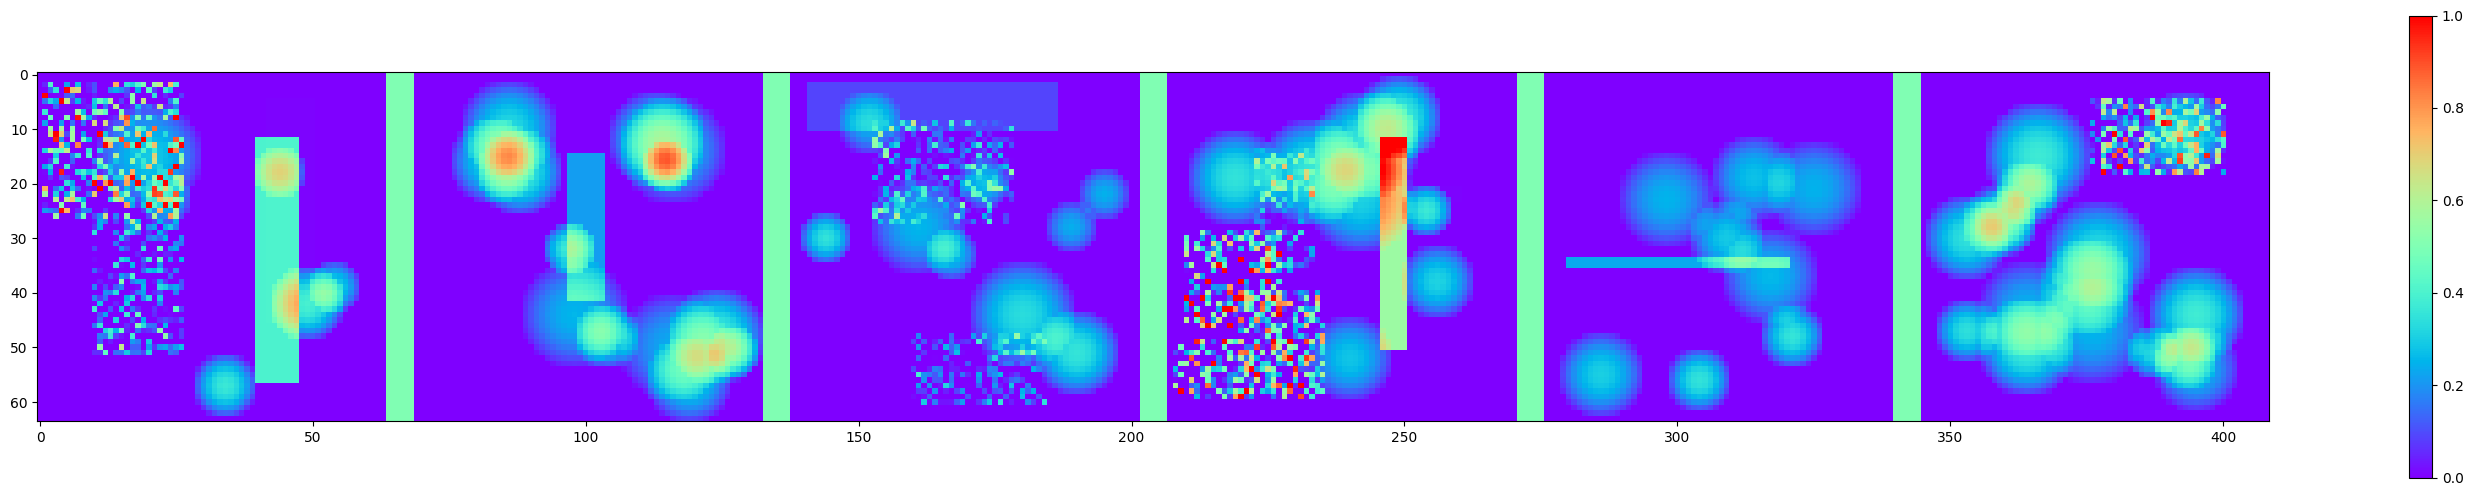

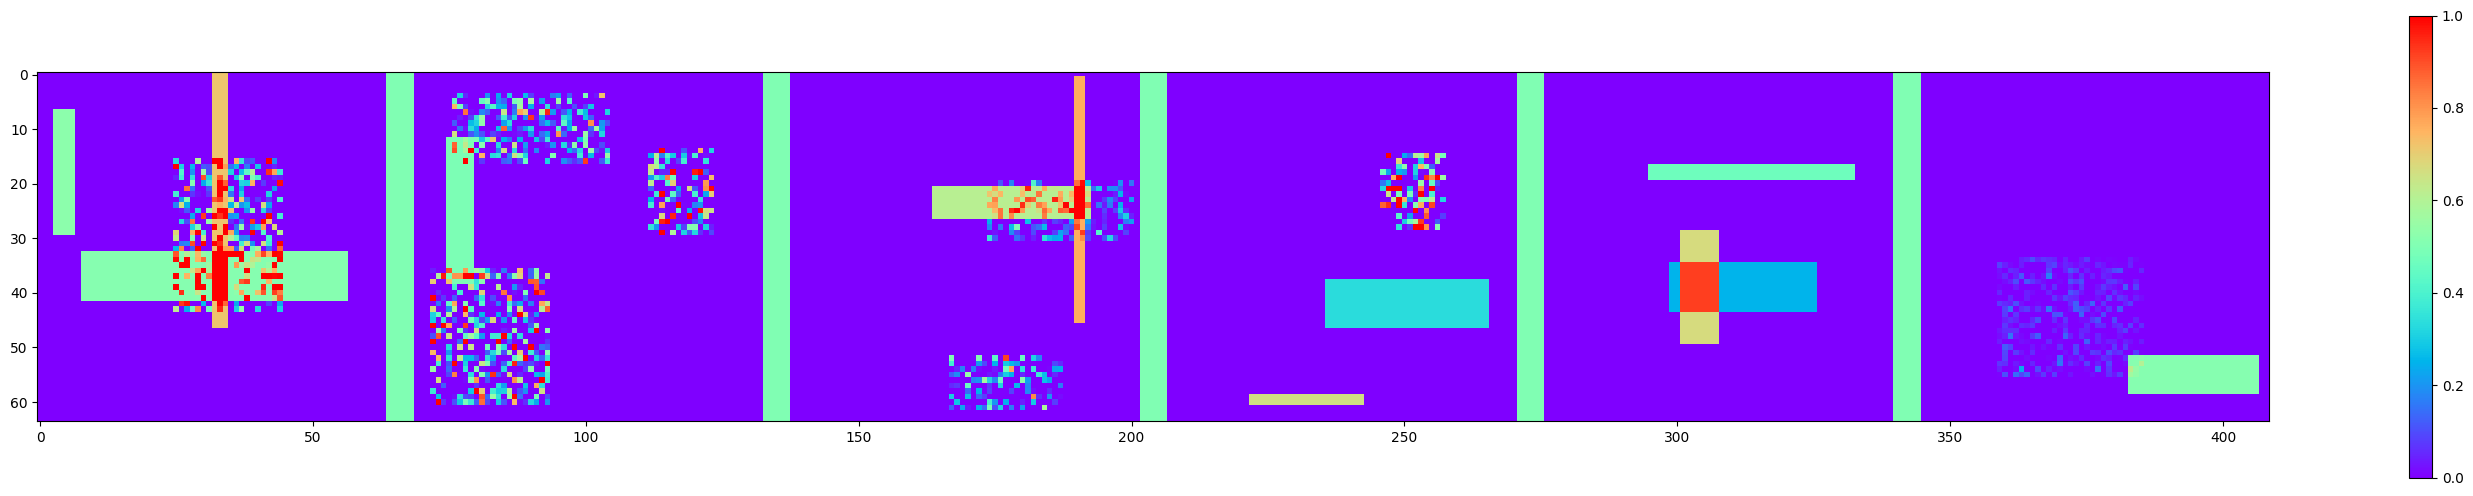

In [12]:
image1 = gen1_NES(6)
noise = gen2_NES(6)

# sample the noisy pictures:
fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(image1, 6, fig, k=0, min_scale=0,max_scale=1)

# sample noise:
fig2 = plt.figure(1, figsize=(36, 6))
voir_batch2D(noise, 6, fig2, k=0, min_scale=0,max_scale=1)

**Q1** Propose a learning strategy that leads to effective denoising.

**Q2** Discuss the limitations of the method and mention some avenues for improvement.

Q1 On pourrait ajouter du bruit à l'image déjà puisque le procédé de bruitage est connu nous donnant ainsi une autre image avec l'objet d'intérêt bruité d'une autre façon et on applique le même procédé que précédemment. Le bruit ajouté doit être dominant par rapport aux artefacts de base.

Q2 La méthode implique de réutiliser du bruit déjà présent, ce qui pourrait rendre la tâche de débruitage pour le réseau de neurones impossible.

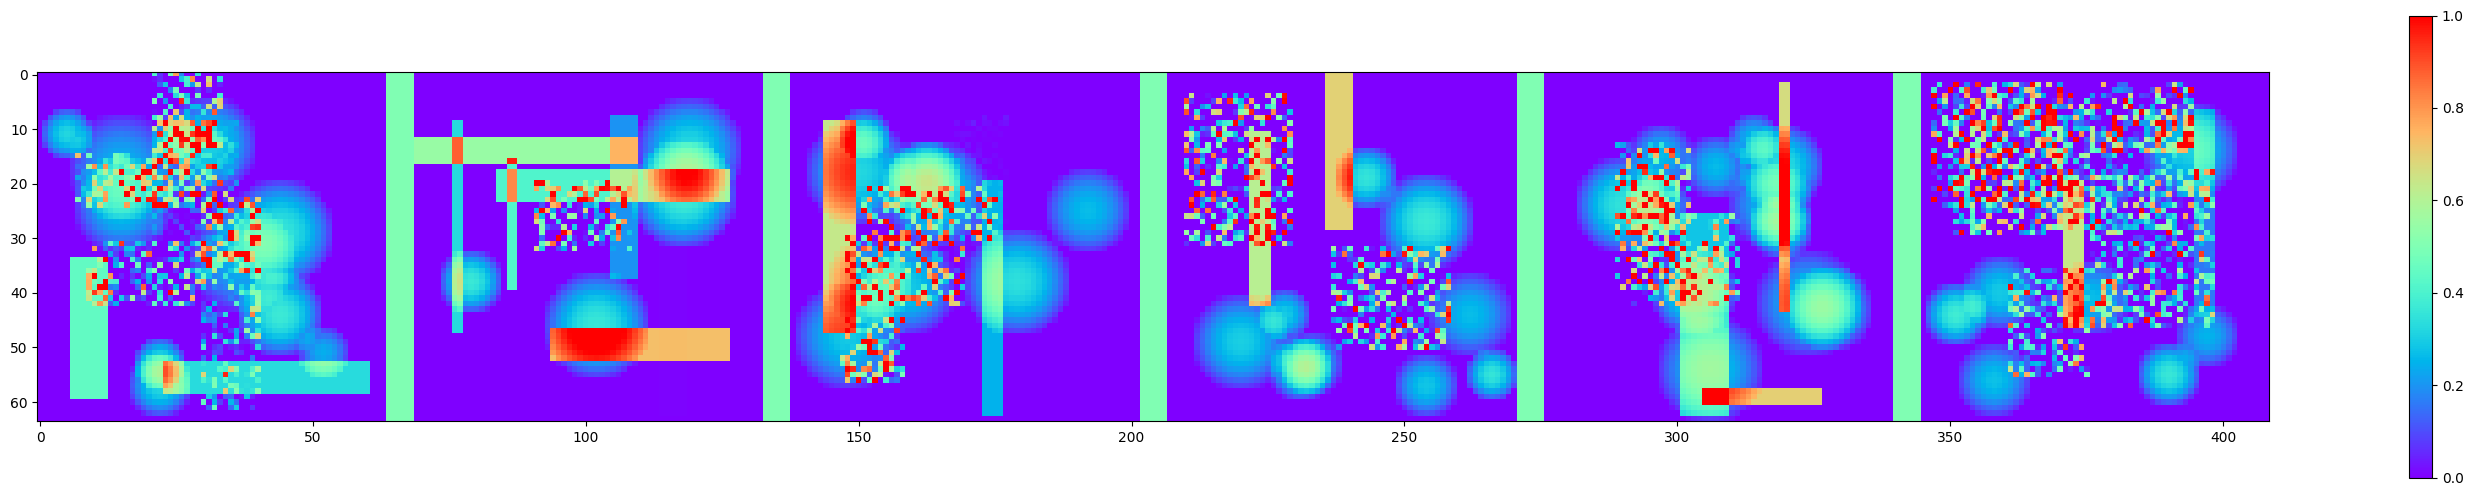

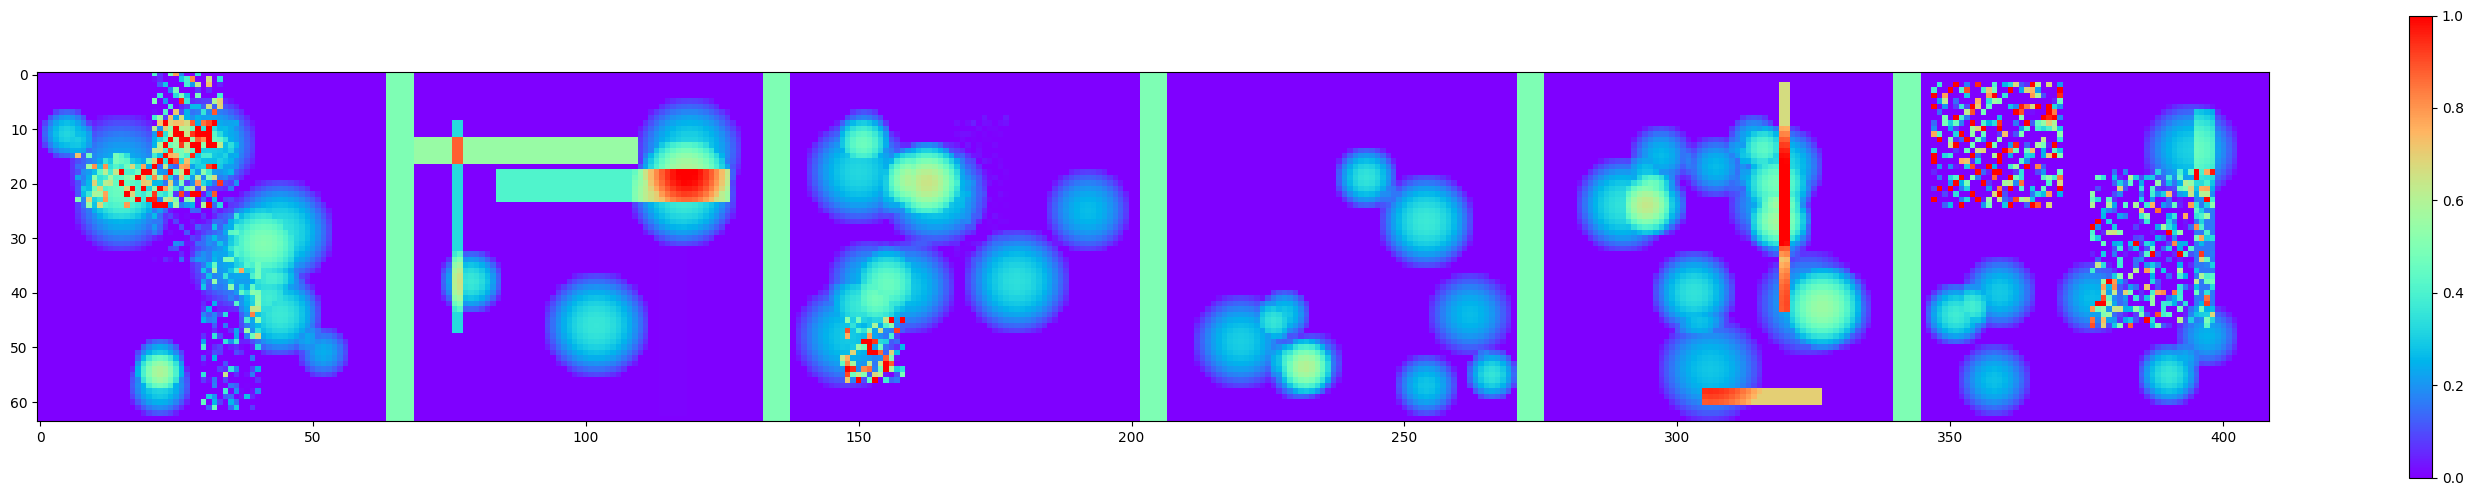

In [13]:
image = gen1_NES(6)
noise1 = gen2_NES(6)
noise2 = gen2_NES(6)

input = image + noise1 + noise2

target = image

# sample the noisy pictures:
fig = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig, k=0, min_scale=0,max_scale=1)

# sample noise:
fig2 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig2, k=0, min_scale=0,max_scale=1)

In [14]:
fcn = UNet(1,1,16).cuda()

import torch.optim as optim
optimizer = optim.Adam(fcn.parameters(), 10**(-3))

In [15]:
nepochs = 40
nbatches = 100
batchsize = 64

train_losses = []


def criterion(output,target):
  return torch.mean(torch.abs(output - target))

for epoch in range(nepochs):

    print("Epoch " + str(epoch))
    epoch_losses  = []
    for i in range(nbatches):
        #Load inputs

        # Generation
        target = gen1_NES(batchsize)
        noise1 = gen2_NES(batchsize)
        noise2 = gen2_NES(batchsize)

        input = target + noise1 + noise2

        # go to GPU
        input = input.cuda()
        target = target.cuda()

        # zeroing gradients, forward pass
        optimizer.zero_grad()
        output = fcn(input)

        # loss and compuation of gradients
        loss = criterion(output, target)
        loss.backward()

        # Update weights
        optimizer.step()

        epoch_losses.append(loss.detach().cpu())

        del target, input, loss
        torch.cuda.empty_cache()

    epoch_loss = np.mean(epoch_losses)
    train_losses.append(epoch_loss)
    print('epoch loss : \n')
    print(epoch_loss)

Epoch 0
epoch loss : 

0.08953625
Epoch 1
epoch loss : 

0.06469891
Epoch 2
epoch loss : 

0.06032809
Epoch 3
epoch loss : 

0.05699203
Epoch 4
epoch loss : 

0.054735586
Epoch 5
epoch loss : 

0.053632215
Epoch 6
epoch loss : 

0.05233473
Epoch 7
epoch loss : 

0.051817704
Epoch 8
epoch loss : 

0.050886955
Epoch 9
epoch loss : 

0.051242456
Epoch 10
epoch loss : 

0.050029106
Epoch 11
epoch loss : 

0.05054913
Epoch 12
epoch loss : 

0.049754463
Epoch 13
epoch loss : 

0.049493562
Epoch 14
epoch loss : 

0.050270393
Epoch 15
epoch loss : 

0.04972209
Epoch 16
epoch loss : 

0.048688564
Epoch 17
epoch loss : 

0.04877148
Epoch 18
epoch loss : 

0.048851777
Epoch 19
epoch loss : 

0.04818606
Epoch 20
epoch loss : 

0.048296638
Epoch 21
epoch loss : 

0.048660804
Epoch 22
epoch loss : 

0.048601646
Epoch 23
epoch loss : 

0.04792294
Epoch 24
epoch loss : 

0.04858892
Epoch 25
epoch loss : 

0.048391595
Epoch 26
epoch loss : 

0.047967814
Epoch 27
epoch loss : 

0.048246346
Epoch 28
epoc

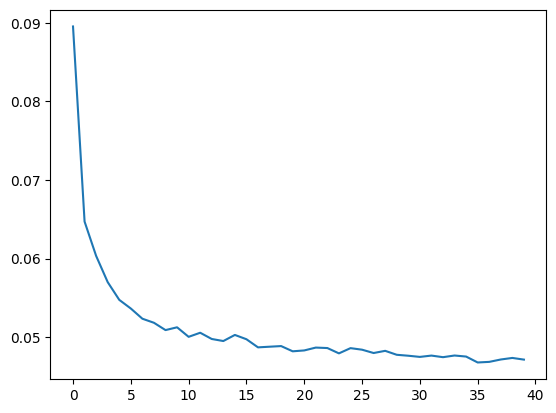

In [17]:
plt.plot(train_losses)

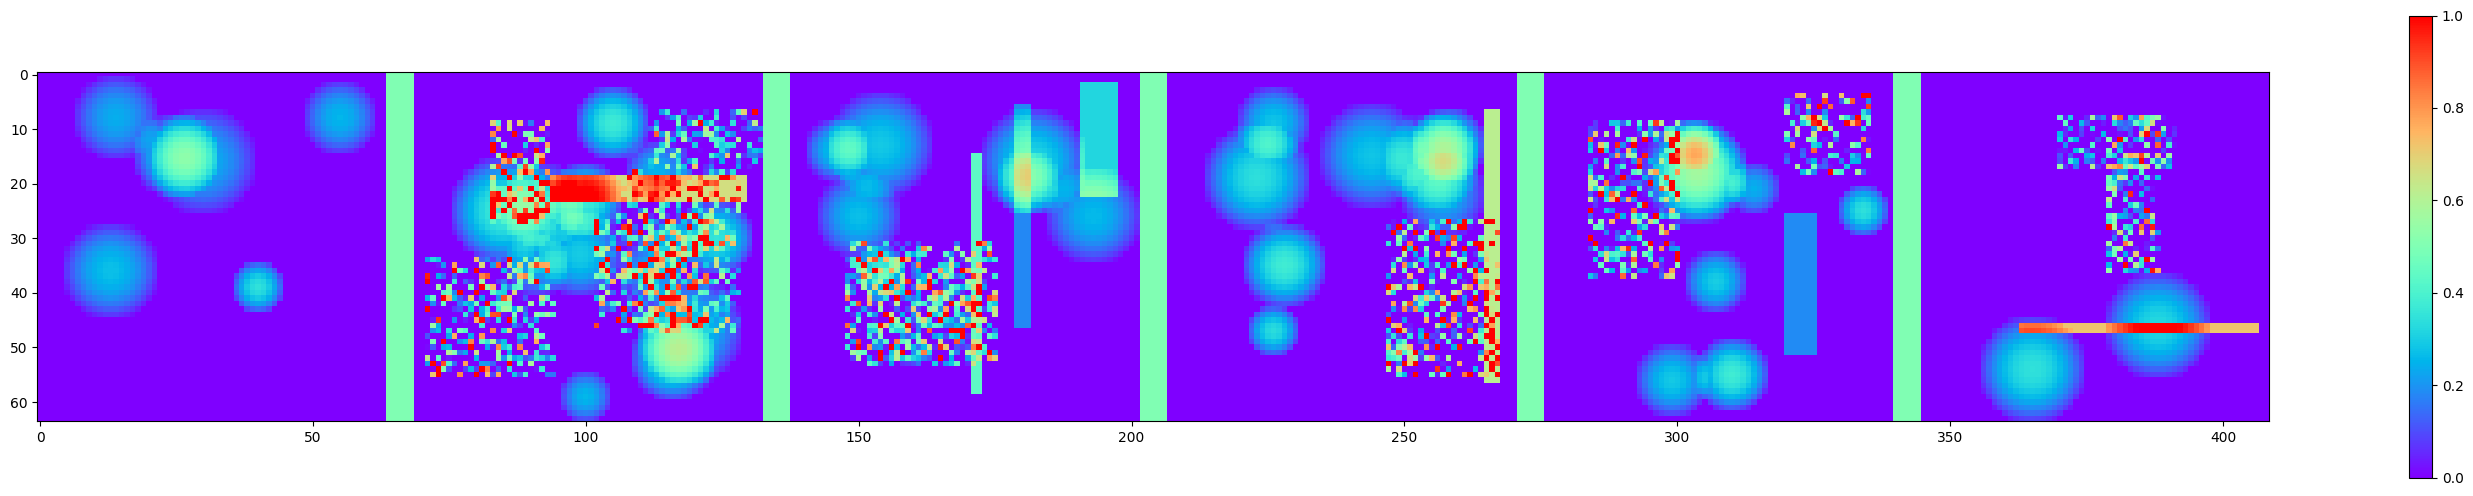

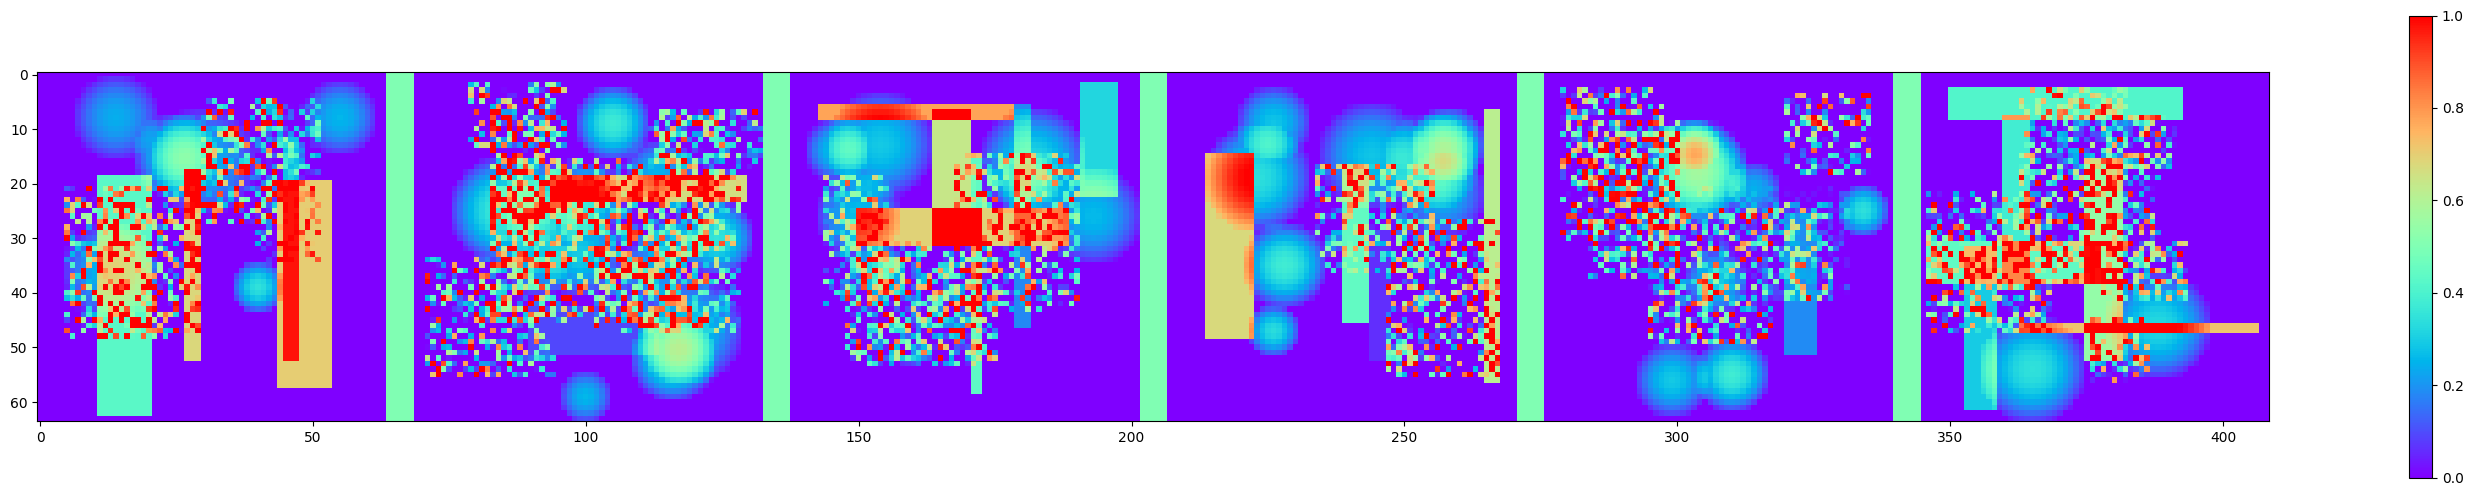

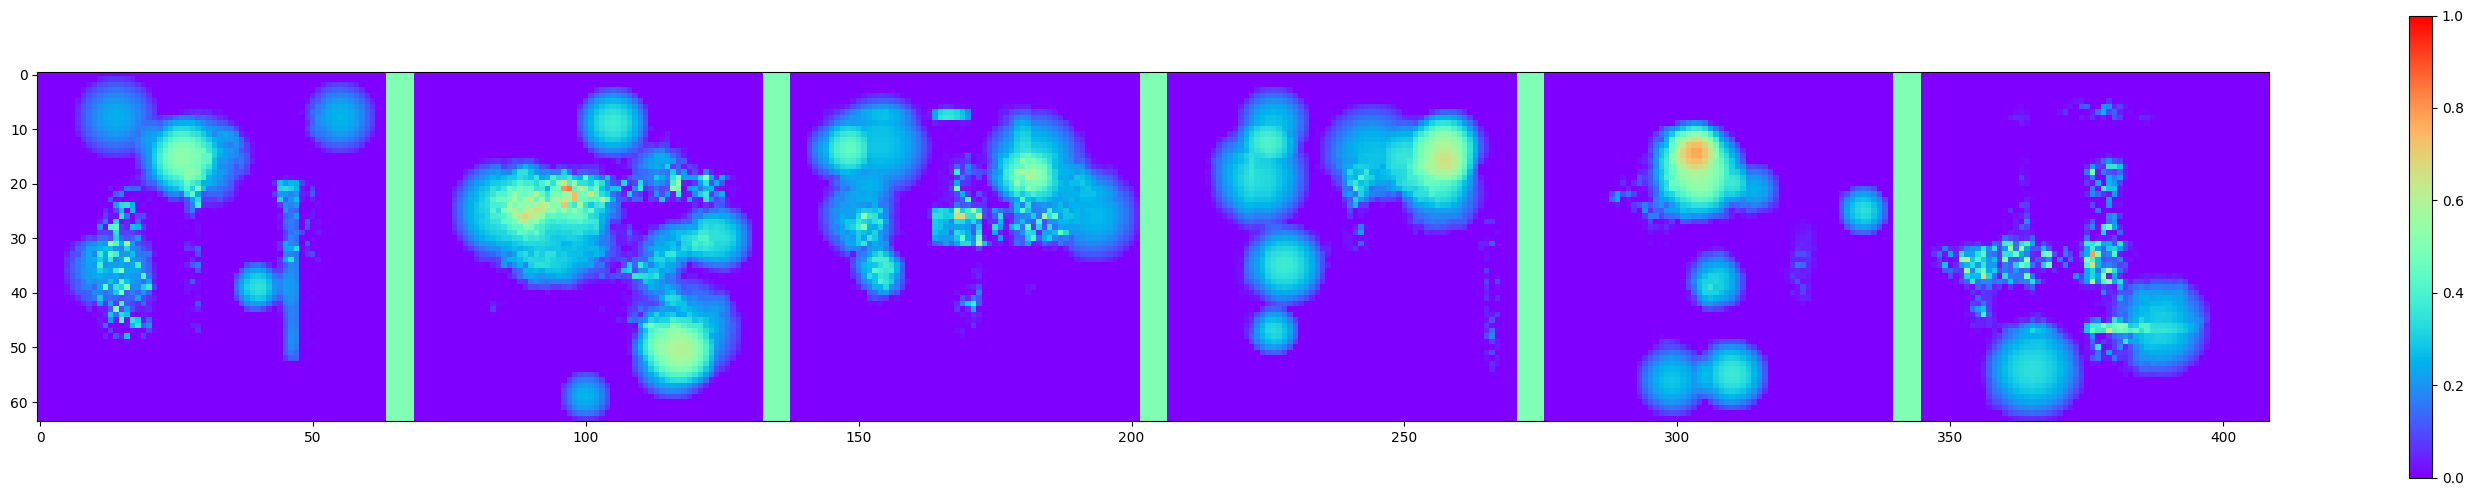

In [20]:
fcn.eval()
target = gen1_NES(6)
noise1 = gen2_NES(6)
noise2 = gen2_NES(6)

input = target + noise1 + noise2
input = input.cuda()

output = fcn(input)

output = output.to('cpu').detach()

input = input.to('cpu')

fig2 = plt.figure(1, figsize=(36, 6))
voir_batch2D(target, 6, fig3, k=0, min_scale=0,max_scale=1)

fig3 = plt.figure(2, figsize=(36, 6))
voir_batch2D(input, 6, fig3, k=0, min_scale=0,max_scale=1)

fig4 = plt.figure(3, figsize=(36, 6))
voir_batch2D(output, 6, fig3, k=0, min_scale=0,max_scale=1)